In [101]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')


model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')

model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [102]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [103]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [104]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [105]:
x_pre = imputer.transform(dfpre)

In [106]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [107]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [108]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [109]:
dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [110]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [111]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [112]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,198.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,195.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,190.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,183.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [113]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [114]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

Special Section

In [115]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Measure performance in one month

In [116]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,201.771601,85.654121
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,205.671971,70.585227
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,212.436488,70.557348
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,230.510505,80.584748
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,254.157471,89.447596


In [117]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [118]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [119]:
stats2 = dfdate6['curspeed'].value_counts()

In [120]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [121]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [122]:
xdate = imputer.transform(dfdate6)

In [123]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [124]:
x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [125]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type,y_predicted):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_pred_rfr_ftr = predict_y(x_date,model_rfr_ftr)
display_scores(x_date,y_date,model_rfr_ftr,y_pred_rfr_ftr)

R^2 score (Indicate model fit. Best Score = 1): 0.8661050856280904
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8850235304894934
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8120179128967392
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.2579811826079608
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.6359169406449978


In [126]:
# Prediction using FTR + HPO optimized for test data

# y_pred_rfr_hpo = predict_y(x_date,model_rfr_hpo)
# display_scores(x_date,y_date,model_rfr_hpo,y_pred_rfr_hpo)


In [127]:
# Prediction using FTR + HPO optimized for validation data 

y_pred_rfr_hpov = predict_y(x_date,model_rfr_hpov)
display_scores(x_date,y_date,model_rfr_hpo,y_pred_rfr_hpov)

R^2 score (Indicate model fit. Best Score = 1): 0.8593938939009967
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8833358139977985
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8198246903731582
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.2671003603617133
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.6609920558321223


In [128]:
# Comparing performance with DTR model (not optimzed)

y_pred_dtr_ftr = predict_y(x_date,model_dtr_ftr)
display_scores(x_date,y_date,model_dtr_ftr,y_pred_dtr_ftr)

R^2 score (Indicate model fit. Best Score = 1): 0.814343145225526
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8345189699106536
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.977445138978261
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.7442994816049961
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.7392370600000007


In [129]:
# Comparing performance with MLR as baseline (not optimzed)

y_pred_mlr_ftr = predict_y(x_date,model_mlr_ftr)
display_scores(x_date,y_date,model_mlr_ftr,y_pred_mlr_ftr)

R^2 score (Indicate model fit. Best Score = 1): 0.5739398047508771
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.596392988232809
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.4264762308245376
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 4.002957922605872
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 1.2897330038744244


In [130]:
ydate_pred = y_pred_rfr_hpo
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred      gamma    nwinddir
119   18.998906  18.269814  85.654121  201.771601
120   19.334278  18.642684  70.585227  205.671971
121   18.911047  18.481519  70.557348  212.436488
122   13.854933  14.031871  80.584748  230.510505
126    9.305198  11.660167  89.447596  254.157471
...         ...        ...        ...         ...
7413  19.072622  18.347368 -75.033834  110.959927
7414  17.696584  17.518632  86.330174  126.837339
7415  15.963630  16.468861  83.486098  119.018621
7418   8.988086   8.484219  89.745593  140.723377
7419  17.672769  17.371800  15.792214  143.902554

[322 rows x 4 columns]


In [131]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.269814,85.654121,201.771601
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.642684,70.585227,205.671971
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.481519,70.557348,212.436488
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,14.031871,80.584748,230.510505
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,11.660167,89.447596,254.157471
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.381529,85.735437,252.289134
128,275.499359,5.927387,287.021892,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,12.212180,87.870444,240.000273
130,276.370789,5.959699,286.794441,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,15.985079,-84.704755,248.405148
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.150184,82.800757,264.710374
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.498373,-78.378834,269.075598


In [132]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [133]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["cog"])

In [134]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [135]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [136]:
# For the actual data
dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = dfprog["vwms_a"]*1.9438

# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438



In [137]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vgms_act','vgx_act','stw_x_act',
                      'vgy_act','stw_y_act',
                      'vwms_p','vwms_a'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,164.871808,57.268527,18.998906,18.269814,85.654121,201.771601,18.729972,18.000888
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,153.650411,51.313932,19.334278,18.642684,70.585227,205.671971,18.913459,18.221915
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,153.031589,46.894106,18.911047,18.481519,70.557348,212.436488,18.429833,18.000352
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,153.643227,56.527939,13.854933,14.031871,80.584748,230.510505,13.276732,13.453668
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,41.766758,167.192888,9.305198,11.660167,89.447596,254.157471,9.009772,11.362806
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,36.203894,119.939682,20.935741,17.381529,85.735437,252.289134,21.221281,17.667275
128,275.499359,5.927387,287.021892,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,16.745666,176.253205,12.419853,12.212180,87.870444,240.000273,12.753846,12.546298
130,276.370789,5.959699,286.794441,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,148.640604,54.778275,20.447721,15.985079,-84.704755,248.405148,20.747280,16.284905
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,154.901600,41.385363,18.702889,16.150184,82.800757,264.710374,18.470818,15.918169
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,10.961510,159.775304,16.155258,16.498373,-78.378834,269.075598,15.886581,16.229695


In [138]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,3.393579,287.278174,0.655332,5.282713,197.436423,189.432992,5.832751,0.092478,86.173628,86.811052,96.133203,17.449699,17.023781,-11.849461,179.967365,17.440998,17.015087
std,6.306975,0.964939,4.798404,0.542441,0.162420,86.327689,88.499255,3.020207,0.068917,62.588681,59.359251,61.547388,3.069944,2.667389,55.353826,63.036318,3.059230,2.646855
min,269.606903,1.915993,275.485352,0.073242,4.754639,82.664990,79.551648,0.441768,0.002006,0.565115,1.295289,0.200645,5.224523,6.409622,-89.500098,90.107133,5.211211,6.440262
25%,285.292786,2.692099,286.837568,0.272528,5.199718,103.569971,101.685445,3.442231,0.043318,24.875738,28.600108,35.663590,16.568861,16.681853,-60.671287,119.047681,16.581974,16.640209
50%,289.505615,3.162097,289.004578,0.465021,5.290842,193.360899,125.125521,5.528616,0.073482,82.212973,79.271353,103.381967,18.413643,18.028522,-26.065061,170.499216,18.399973,17.972429
75%,291.391602,3.734216,290.458008,0.769191,5.381292,283.259801,279.238872,7.569939,0.123647,149.107733,146.039105,158.470366,19.421633,18.565530,35.032562,244.414903,19.417551,18.552044
max,294.685303,6.291378,292.665649,2.565230,5.657671,319.851509,304.969531,13.386999,0.417155,179.309007,179.405213,179.699225,21.031230,19.753465,89.975398,269.737370,21.221281,19.839617


In [139]:
# FOC in T/d
dfprog["foc_act_d"] = ((dfprog["stw_act"]/17.7)**3) * 21.14112
dfprog["foc_pred_d"] = ((dfprog["stw_pred"]/17.7)**3) * 21.14112

# FOC in T/h
dfprog["foc_act_h"] = ((dfprog["stw_act"]/17.7)**3) * 0.8808
dfprog["foc_pred_h"] = ((dfprog["stw_pred"]/17.7)**3) * 0.8808

In [140]:
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,...,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred,foc_act_d,foc_pred_d,foc_act_h,foc_pred_h
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,100.989288,...,18.998906,18.269814,85.654121,201.771601,18.729972,18.000888,25.050684,22.237707,1.043684,0.926487
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,108.737155,...,19.334278,18.642684,70.585227,205.671971,18.913459,18.221915,25.794140,23.066952,1.074658,0.961036
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,114.910729,...,18.911047,18.481519,70.557348,212.436488,18.429833,18.000352,23.865601,22.235720,0.994310,0.926404
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,123.568984,...,13.854933,14.031871,80.584748,230.510505,13.276732,13.453668,8.922402,9.283897,0.371733,0.386794
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,26.476633,...,9.305198,11.660167,89.447596,254.157471,9.009772,11.362806,2.788365,5.593259,0.116171,0.233031
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,49.650197,...,20.935741,17.381529,85.735437,252.289134,21.221281,17.667275,36.435353,21.024075,1.518002,0.875924
128,275.499359,5.927387,287.021892,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,11.124505,...,12.419853,12.212180,87.870444,240.000273,12.753846,12.546298,7.909183,7.529306,0.329519,0.313693
130,276.370789,5.959699,286.794441,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,121.750507,...,20.447721,15.985079,-84.704755,248.405148,20.747280,16.284905,34.048008,16.465083,1.418538,0.685983
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,156.811217,...,18.702889,16.150184,82.800757,264.710374,18.470818,15.918169,24.025177,15.377563,1.000958,0.640674
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,1.584058,...,16.155258,16.498373,-78.378834,269.075598,15.886581,16.229695,15.286199,16.298187,0.636867,0.679029


In [141]:
# df_foc=dfprog.drop(['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod',
#                     'surftemp','windwaveswellheight','swellheight','windwaveheight','swellheight',
#                     'windwaveheight','draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir',
#                     'truewavedir','gamma','nwinddir'],axis=1)

df_foc=dfprog.drop(['oceantemperature','waveperiod',
                    'surftemp','windwaveswellheight',
                    'draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir',
                    'truewavedir','gamma','nwinddir'],axis=1)

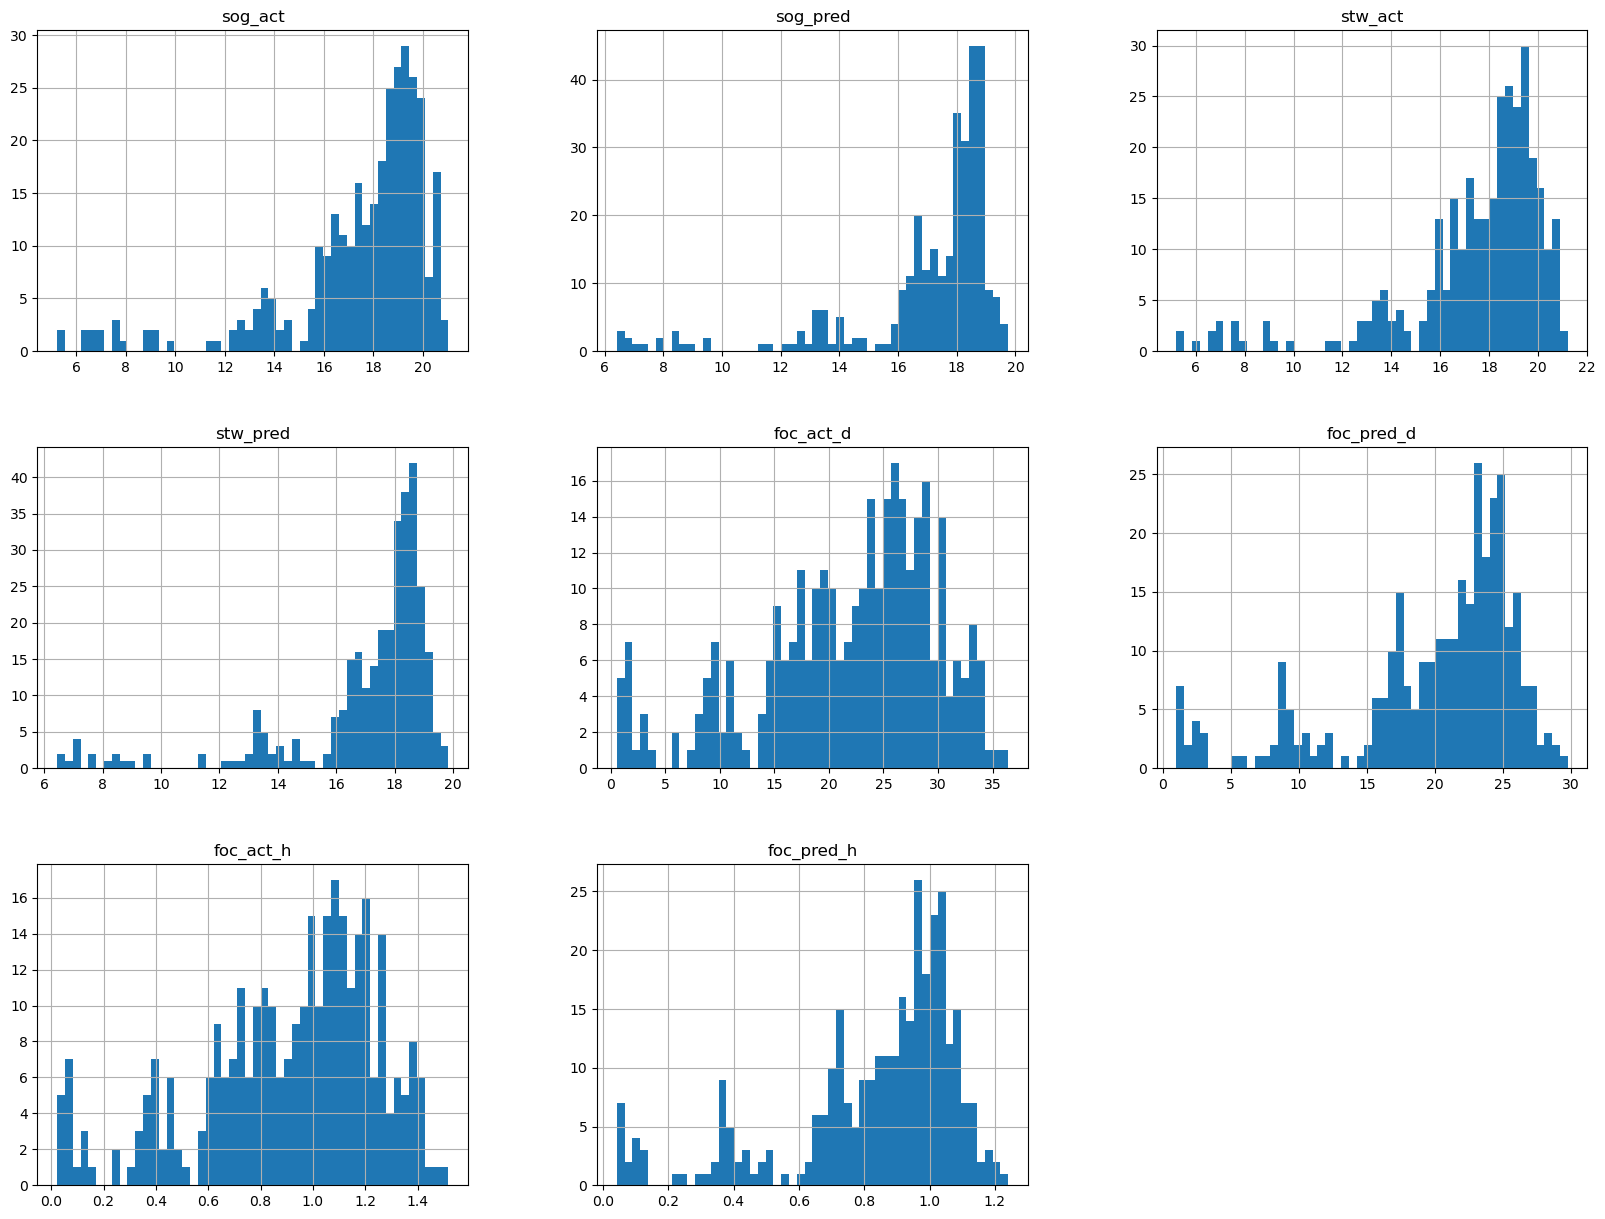

In [142]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_foc.hist(bins=50,figsize=(20,15))
plt.show()

In [143]:
foc_month = dfprog['foc_pred_d'].mean()
foc_month_a = dfprog['foc_act_d'].mean()
print(f"Mean of predicted FOC in a month is {foc_month} T/d")
print(f"Mean of actual FOC in a month is {foc_month_a} T/d")

Mean of predicted FOC in a month is 19.978359055963043 T/d
Mean of actual FOC in a month is 21.87772146283159 T/d


In [144]:
foc_trip = dfprog['foc_pred_h'].mean() * 4
foc_trip_a = dfprog['foc_act_h'].mean() * 4
foc_trip_err = foc_trip_a - foc_trip
print(f"Mean of predicted FOC in a 4h trip is {foc_trip} T")
print(f"Mean of actual FOC in a trip in a 4h trip is {foc_trip_a} T")
print(f"Error is {foc_trip_err} T")

Mean of predicted FOC in a 4h trip is 3.329424109317245 T
Mean of actual FOC in a trip in a 4h trip is 3.6459557609931856 T
Error is 0.31653165167594066 T


Hyperparameter Optimization

In [145]:
from pprint import pprint
pprint(model_rfr_ftr.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [146]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200, None],
 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300]}


In [147]:
rf_random = RandomizedSearchCV(estimator = model_rfr_ftr, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(x_date, y_date)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 31, 52, 73, 94, 115,
                                                      136, 157, 178, 200,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 12],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 42, 74, 106, 138,
                                                         171, 203, 235, 267,
                                                         300]},
                   random_state=42, verbose=2)

In [148]:
rf_random.best_params_

{'n_estimators': 267,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 9,
 'max_depth': 136,
 'bootstrap': False}

In [150]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

    predictions = model.predict(test_features)
    rsquared = model.score(test_features,test_labels)
    expVar = explained_variance_score(test_labels,predictions)
    MAE = mean_absolute_error(test_labels,predictions)
    MAD = median_absolute_error(test_labels,predictions)
    RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")
    
    return rsquared,expVar,MAE,RMSE,MAD

base_model = model_rfr_hpov
base_model.fit(x_date, y_date)
rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

best_random = rf_random.best_estimator_
rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_date, y_date)
print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0

Model Performance of RandomForestRegressor(max_depth=115, max_features=12, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=74, random_state=42)
R^2: 0.9601
explained Variance = 0.9601
MAE = 0.3705
RMSE = 0.6124
MAD = 0.2446

Model Performance of RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267)
R^2: 0.9971
explained Variance = 0.9971
MAE = 0.0917
RMSE = 0.1637
MAD = 0.0507

Improvement of Rsquared 3.860%.
Improvement of explainedVariance 3.856%.
Improvement of MAE 75.238%.
Improvement of RMSE 73.262%.
Improvement of MAD 79.283%.
